# Modlue 2. Training with CutMix
---

본 모듈에서는 Amzaon SageMaker API 호출 없이 PyTorch 프레임워크 자체 구현만으로 모델 훈련을 수행해 봅니다. PyTorch의 문법 및 용법에 익숙하신 분들은 이 모듈을 건너 뛰고 Module 3으로 곧바로 진행하셔도 됩니다.

훈련을 원활하게 수행하시려면 GPU가 장착된 SageMaker notebook instance를 사용하셔야 합니다. (예: `ml.g4dn.xlarge, ml.p2.xlarge, ml.p3.2xlarge`)

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import time, datetime
import gc, glob2
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import joblib

HEIGHT = 137
WIDTH = 236
BATCH_SIZE = 256

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 1. Splits Data

Metric 평가를 위해, 훈련 데이터셋/검증 데이터셋을 분리합니다. 본 핸즈온에서는 훈련 데이터셋을 5-fold로 분리 후 4번째 fold를 검증 데이터셋으로 사용하겠습니다.

In [2]:
train_df = pd.read_csv('./input/train_folds.csv')

num_folds = 5
vld_fold_idx = 4
trn_fold = [i for i in range(num_folds) if i not in [vld_fold_idx]]
vld_fold = [vld_fold_idx]

trn_idx = train_df.loc[train_df['fold'].isin(trn_fold)].index
vld_idx = train_df.loc[train_df['fold'].isin(vld_fold)].index

## 2. Data Transformation w/ Augmentation

본 핸즈온에서는 `albumentations` 패키지를 사용하여 Data augmentation을 수행합니다. 물론 `torchvision.transforms`에서도 이미 augmentation을 지원하고 있지만, 더 많은 augmentation 기법들을 지원하고 있으며 수행 속도 또한 훨씬 빠릅니다.
관련 내용은 아래 URL을 참조해 주세요.

- [Albumentations: fast and flexible image augmentations](https://arxiv.org/pdf/1809.06839.pdf)
- [migrating_from_torchvision_to_albumentations.ipynb](https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb)

In [3]:
import albumentations as A
from albumentations import (
    Rotate,HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf
)
from albumentations.pytorch.transforms import ToTensor

train_transforms = A.Compose([
    Rotate(20),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ToTensor()
    ], p=1.0)


valid_transforms = A.Compose([
    ToTensor()
])

## 3. Make DataLoader
PyTorch는 미니배치를 쉽게 로딩할 수 있는 `torch.utils.data.Dataset`과 `torch.utils.data.DataLoader`를 제공하며, 이를 사용하여
미니배치 셔플링(shuffling), 병렬 처리를 쉽게 구현할 수 있습니다.

또한, `torch.utils.data.Dataset`을 상속받아 사용자 정의 Dataset을 아래와 같이 쉽게 구성할 수 있습니다.<br>
사용자 정의 Dataset 구현의 기본적인 뼈대는 데이터셋 초기화에 필요한 `__init__(self)` 메서드, 데이터셋의 총 샘플 수를 리턴해 주는 `__len__(self)` 메서드, 특정 1개의 샘플을 가져오는 `__getitem__(self, index)` 메서드의 구현입니다.

### Get Images
parquet 파일을 로딩하여 dataframe로 저장한 후, numpy array로 변환하여 전체 데이터셋을 메모리에 저장합니다.
본 핸즈온은 데이터셋 크기가 크지 않아 전체 이미지 데이터를 메모리에 올렸지만, 수백만장 이상의 대용량 데이터 사용 시에는 데이터셋을 TFRecord, RecordIO와 같은 직렬 파일로 인코딩하여 저장하거나 각 이미지를 pickle로 저장해야 합니다.

In [4]:
%%time

def get_images(data_dir='input', data_type='train'):
    files = sorted(glob2.glob(f'{data_dir}/{data_type}_*.feather'))

    image_df_list = [pd.read_feather(f) for f in files]
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

imgs = get_images(data_type='train')
test_imgs = get_images(data_type='test')

CPU times: user 30.4 s, sys: 22.7 s, total: 53.2 s
Wall time: 21.3 s


테스트 데이터를 `jpg` 파일로 변환하여 저장합니다. 이 파일들은 모델 배포 시 테스트 이미지로 활용하게 됩니다.

In [5]:
test_dir = os.path.join(os.getcwd(), 'test_imgs')
os.makedirs(test_dir, exist_ok=True)

for idx, img_arr in enumerate(test_imgs):
    img = Image.fromarray(test_imgs[idx])
    img.save(f'test_imgs/test_{idx}.jpg')

### Custom Dataset 클래스 정의
`__getitem__(self, idx)`을 통해 데이터셋 전체를 메모리에 올리지 않고 특정 샘플이 필요할 때에만 불러와서 읽습니다.

In [6]:
class BangaliDataset(Dataset):
    def __init__(self, imgs, label_df=None, transform=None):
        self.imgs = imgs
        self.label_df = label_df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, idx):
        
        img_idx = self.label_df.iloc[idx].id
        img = (self.imgs[img_idx]).astype(np.uint8)
        img = 255 - img
    
        img = img[:,:,np.newaxis]
        img = np.repeat(img, 3, axis=2)
        
        if self.transform is not None:
            img = self.transform(image=img)['image']        
        
        if self.label_df is not None:
            label_1 = self.label_df.iloc[idx].grapheme_root
            label_2 = self.label_df.iloc[idx].vowel_diacritic
            label_3 = self.label_df.iloc[idx].consonant_diacritic           
            return img, np.array([label_1, label_2, label_3])        
        else:
            return img

### Dataset 인스턴스 생성

In [7]:
from torch.utils.data import Dataset, DataLoader
trn_dataset = BangaliDataset(imgs=imgs, label_df=train_df.loc[trn_idx], transform=train_transforms)
vld_dataset = BangaliDataset(imgs=imgs, label_df=train_df.loc[vld_idx], transform=valid_transforms)

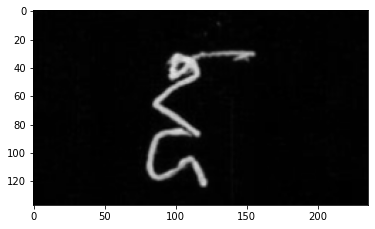

In [8]:
idx = np.random.randint(len(trn_idx))
img_sample = trn_dataset[idx][0].permute(1, 2, 0).numpy().squeeze()
plt.imshow(img_sample, cmap='gray')

### DataLoader 인스턴스 생성

In [9]:
trn_loader = DataLoader(trn_dataset, shuffle=True, num_workers=4, batch_size=BATCH_SIZE)
vld_loader = DataLoader(vld_dataset, shuffle=False, num_workers=4, batch_size=BATCH_SIZE)

## 4. Make model, optimizer, and criterion for Transfer Learning

모델 파라메터들을 random 분포로 초기화화여 훈련하는 것보다 이미 ImageNet 데이터로 pre-trained되어 있는 모델 파라메터를 사용하는 것이 더 효율적으로 훈련을 수행하는 방법입니다. 
어떤 모델을 사용해도 무방하지만, 본 핸즈온에서는 비교적 간단한 모델인 ResNet-18을 사용하도록 하겠습니다.

In [10]:
from torchvision import datasets, models

model = models.resnet18(pretrained=True)
last_hidden_units = model.fc.in_features
model.fc = torch.nn.Linear(last_hidden_units, 186)
model = model.cuda()

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                      verbose=True, patience=5, 
                                                      factor=0.5)

## 5. Training
`ml.p3.2xlarge` 노트북 인스턴스 기준으로 epoch당 5분 30초~5분 40초 정도 소요됩니다. 원활한 핸즈온을 위해 본 section은 건너뛰어도 되며, 이미 훈련이 완료된 모델을 그대로 사용하시면 됩니다.

In [12]:
from tqdm import tqdm

def rand_bbox(size, lam):
    '''
    CutMix Helper function.
    Retrieved from https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
    '''
    W = size[2]
    H = size[3]
    # 폭과 높이는 주어진 이미지의 폭과 높이의 beta distribution에서 뽑은 lambda로 얻는다
    cut_rat = np.sqrt(1. - lam)
    
    # patch size 의 w, h 는 original image 의 w,h 에 np.sqrt(1-lambda) 를 곱해준 값입니다.
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # patch의 중심점은 uniform하게 뽑힘
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

best_score = -1
log_interval = 10
training_stats = []
num_epochs = 1

for epoch_id in range(num_epochs):

    ################################################################################
    # ==> Training phase
    ################################################################################    
    trn_loss = []
    model.train()
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    running_loss = 0.0
    
    for batch_id, (inputs, targets) in enumerate((trn_loader)):
        inputs = inputs.cuda()
        targets = targets.cuda()
        targets_gra = targets[:, 0]
        targets_vow = targets[:, 1]
        targets_con = targets[:, 2]
                    
        # 50%의 확률로 원본 데이터 그대로 사용    
        if np.random.rand() < 0.5:
            logits = model(inputs)
            grapheme = logits[:, :168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]
            
            loss1 = loss_fn(grapheme, targets_gra)
            loss2 = loss_fn(vowel, targets_vow)
            loss3 = loss_fn(cons, targets_con) 
        
        else:
            
            lam = np.random.beta(1.0, 1.0) 
            rand_index = torch.randperm(inputs.size()[0])
            shuffled_targets_gra = targets_gra[rand_index]
            shuffled_targets_vow = targets_vow[rand_index]
            shuffled_targets_con = targets_con[rand_index]
            
            bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
            inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
            # 픽셀 비율과 정확히 일치하도록 lambda 파라메터 조정  
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
            
            logits = model(inputs)
            grapheme = logits[:,:168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]
            
            loss1 = loss_fn(grapheme, targets_gra) * lam + loss_fn(grapheme, shuffled_targets_gra) * (1. - lam)
            loss2 = loss_fn(vowel, targets_vow) * lam + loss_fn(vowel, shuffled_targets_vow) * (1. - lam)
            loss3 = loss_fn(cons, targets_con) * lam + loss_fn(cons, shuffled_targets_con) * (1. - lam)
        
        loss = 0.5 * loss1 + 0.25 * loss2 + 0.25 * loss3    
        trn_loss.append(loss.item())
        running_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # Printing vital information
        if (batch_id + 1) % (log_interval) == 0:
            s = f'[Epoch {epoch_id} Batch {batch_id+1}/{len(trn_loader)}] ' \
            f'loss: {running_loss / log_interval:.4f}'
            print(s)
            running_loss = 0

    # Measure how long this epoch took.
    trn_time = format_time(time.time() - t0)        

    ################################################################################
    # ==> Validation phase
    ################################################################################
    val_loss = []
    val_true = []
    val_pred = []
    model.eval()

    with torch.no_grad():
        for inputs, targets in vld_loader:
            inputs = inputs.cuda()
            targets = targets.cuda()
            logits = model(inputs)
            grapheme = logits[:,:168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]

            loss= 0.5* loss_fn(grapheme, targets[:,0]) + 0.25*loss_fn(vowel, targets[:,1]) + \
            0.25*loss_fn(vowel, targets[:,2])
            val_loss.append(loss.item())


            grapheme = grapheme.cpu().argmax(dim=1).data.numpy()
            vowel = vowel.cpu().argmax(dim=1).data.numpy()
            cons = cons.cpu().argmax(dim=1).data.numpy()

            val_true.append(targets.cpu().numpy())
            val_pred.append(np.stack([grapheme, vowel, cons], axis=1))                

    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)
    val_loss = np.mean(val_loss)
    trn_loss = np.mean(trn_loss)

    score_g = recall_score(val_true[:,0], val_pred[:,0], average='macro')
    score_v = recall_score(val_true[:,1], val_pred[:,1], average='macro')
    score_c = recall_score(val_true[:,2], val_pred[:,2], average='macro')
    final_score = np.average([score_g, score_v, score_c], weights=[2,1,1])
   
    # Printing vital information
    print('== Start Validation ==')
    s = f'[Epoch {epoch_id}] ' \
    f'trn_loss: {trn_loss:.4f}, vld_loss: {val_loss:.4f}, score: {final_score:.4f}, ' \
    f'score_each: [{score_g:.4f}, {score_v:.4f}, {score_c:.4f}]'          
    print(s)

    ################################################################################
    # ==> Save checkpoint and training stats
    ################################################################################        
    if final_score > best_score:
        best_score = final_score
        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, 'model.pth')
        
    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_id + 1,
            'trn_loss': trn_loss,
            'trn_time': trn_time,            
            'val_loss': val_loss,
            'score': final_score,
            'score_g': score_g,
            'score_v': score_v,
            'score_c': score_c            
        }
    )            

[Epoch 0 Batch 10/628] loss: 3.2372
[Epoch 0 Batch 20/628] loss: 2.8627
[Epoch 0 Batch 30/628] loss: 2.7950
[Epoch 0 Batch 40/628] loss: 2.6108
[Epoch 0 Batch 50/628] loss: 2.5066
[Epoch 0 Batch 60/628] loss: 1.9175
[Epoch 0 Batch 70/628] loss: 2.0307
[Epoch 0 Batch 80/628] loss: 1.9274
[Epoch 0 Batch 90/628] loss: 2.0999
[Epoch 0 Batch 100/628] loss: 1.8995
[Epoch 0 Batch 110/628] loss: 1.5218
[Epoch 0 Batch 120/628] loss: 0.9903
[Epoch 0 Batch 130/628] loss: 1.1273
[Epoch 0 Batch 140/628] loss: 1.5246
[Epoch 0 Batch 150/628] loss: 1.8000
[Epoch 0 Batch 160/628] loss: 1.6288
[Epoch 0 Batch 170/628] loss: 1.8893
[Epoch 0 Batch 180/628] loss: 1.3271
[Epoch 0 Batch 190/628] loss: 1.2156
[Epoch 0 Batch 200/628] loss: 1.4634
[Epoch 0 Batch 210/628] loss: 1.3027
[Epoch 0 Batch 220/628] loss: 1.2499
[Epoch 0 Batch 230/628] loss: 1.2233
[Epoch 0 Batch 240/628] loss: 2.1157
[Epoch 0 Batch 250/628] loss: 1.4742
[Epoch 0 Batch 260/628] loss: 1.5566
[Epoch 0 Batch 270/628] loss: 1.0336
[Epoch 0 B

## 6. Check training results

훈련 결과를 간단히 살펴봅니다.

In [13]:
import pandas as pd
pd.set_option('precision', 4)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
display(df_stats)

#model.load_state_dict(torch.load('./model.pth'))

,trn_loss,trn_time,val_loss,score,score_g,score_v,score_c
epoch,,,,,,,
1,1.5474,0:11:14,1.2164,0.8985,0.8667,0.9351,0.9253
